## **Dans se fichier kMeansCanny** <br>

On prend en argument une unique image RADAR : *2014-09-11T09-08-52-300.png*<br>

On applique un **pré-traitement de l'image** qui vise à localiser les tâches correspondantes aux cibles détectées par le Radar, par un détourage de chaque tâche avec **l'algorithme Canny** *qui prend 2 paramètres de seuillage allant de 0 à 255* <br>

Puis, On applique la **méthode non supervisée kMeans** en prenant comme feature : **la longueur du contour des tâches**, *l'intêret étant de pouvoir traiter plus facilement par la suite les effets géométriques dûs au radrar.* Et en cleusterinsant en **5 classes** : *l'idée étant de faire ressortir 3 classes de bateaux : Petit, Moyen, Grand & 2 classe Unknow : PetiteAnomalie (ex: remoue de vagues), grandeAnomalie *(contenant les côtes)* <br>

Enfin, afin de **visualiser le clustering** on colore chaque contour de tâche par sa classe associée

### **Importations**

In [8]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

### **Traitement de l'image** <br>

#### Détection contour des tâches

In [9]:
# Chemin vers le répertoire contenant les images radar
image= "../Image radar/2014-09-11T09-08-52-300.png"

# Charger l'image
image = cv2.imread(image) 

# Convertir en niveaux de gris (intéret : Amélioration contraste, simplification du traitement, adaptabilité à la méthode, réduction de la complexité)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Appliquer l'algorithme de détection de contours Canny
edges = cv2.Canny(gray, 50, 150)

# Trouver les contours dans l'image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

### **Méthode non supervisé des K-means** <br>

#### Préparer les features

In [10]:
# Calculer la longueur du contour pour chaque tâche
contour_lengths = [len(contour) for contour in contours]

# Convertir la liste en un tableau numpy
contour_lengths = np.array(contour_lengths).reshape(-1, 1) #Chaque contour est transformé en un vecteur à une dimension

In [11]:
def extract_features(edges):
    features = []

    # Recherche des contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Calcul de l'aire
        area = np.sum(contour)
        
        # Calcul du périmètre
        perimeter = len(contour) 
        # Convertir la liste en un tableau numpy
        
        # Calcul de la circularité
        circularity = (4 * np.pi * area) / (perimeter ** 2)

        # Calcul du rectangle englobant
        _, _, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h

        # Calcul des moments et des moments de Hu
        # moments = cv2.moments(contour)
        # hu_moments = cv2.HuMoments(moments).flatten()
        # print("hu", hu_moments)


        # Ajout des caractéristiques à la liste des features
        features.append([area,perimeter, circularity, aspect_ratio])  #A modifier selon les features que l'on veut area, perimeter, circularity, aspect_ratio, hu_moments
    
    return np.array(features)

In [12]:
features = extract_features(edges)  

#### Appliquer l'algorihtme Kmeans 

In [13]:
# Utiliser KMeans pour regrouper les tâches en 4 clusters
kmeans = KMeans(n_clusters=5)
#kmeans.fit(contour_lengths)
kmeans.fit(features)
labels = kmeans.labels_

C:\Users\lucie.papaix\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### **Visualiser le clustering**

#### Colorer chaque tâche par sa couleur de classe associé par k-means

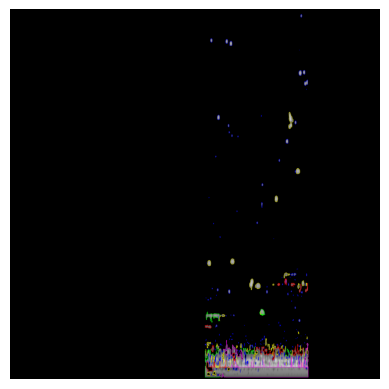

In [14]:
# Dessiner les contours colorés selon leur cluster
image_with_contours = np.copy(image)
for i, contour in enumerate(contours):
    color = (0, 0, 0)  # Couleur par défaut
    if labels[i] == 0:
        color = (255, 0, 0)  # Rouge
    elif labels[i] == 1:
        color = (0, 255, 0)  # Vert
    elif labels[i] == 2:
        color = (0, 0, 255)  # Bleu
    elif labels[i] == 3:
        color = (255, 0, 255)  # Magenta
    elif labels[i] == 4:
        color = (0,255,255) # Cyan

    cv2.drawContours(image_with_contours, [contour], -1, color, 2)

# Afficher l'image avec les contours colorés
plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


## **Conclusion** <br>

l'algorithme kmeans avec détection et traitement des contours des tâches a été efficasse.<br>
On pourrait dire : <br> 
- Classe bleue -> petites cibles 
- Classe rouge -> moyennes cibles
- Classe magenta -> grandes cibles 
- Classe verte -> autres cibles

Sur la zone basse de l'image, mauvaise détection, il faudrait que se soit une unique tâche qui soit associé à la classe *autre cible* ***Piste**: seuillage sur Canny*

**Perspectives**: Effets géométriques *(profondeur, angle, distorsion,...)*, temps, traitement sur plusieurs images, prise en compte de plus de features *(Surface/Aire, Moments de forme [infos/caratéristique & texture de la forme], texture, géométrie)*